In [102]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt

In [103]:
# karas set up
# note: we use keras only for image data generation
from keras import backend as K
K.set_image_data_format('channels_last')
from keras.preprocessing.image import ImageDataGenerator

In [104]:
proj_root = os.path.abspath(os.path.join('../')) 
datadir = os.path.join(proj_root, 'data/labels/')

In [105]:
X1 = np.load(os.path.join(datadir, 'X-1.npy'))
Y1 = np.load(os.path.join(datadir, 'Y-1.npy'))

X2 = np.load(os.path.join(datadir, 'X-2.npy'))
Y2 = np.load(os.path.join(datadir, 'Y-2.npy'))


X = np.vstack((X1, X2))
Y = np.concatenate((Y1, Y2))

X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.5, stratify=Y, random_state=87)

pd.concat([pd.Series(Y_train).value_counts(),
           pd.Series(Y_test).value_counts()], axis=1)

,0,1
b'0',8,8
b'1',51,50
b'2',16,15
b'3',11,10
b'4',10,10
b'5',10,11
b'6',11,10
b'7',10,10
b'8',11,11
b'9',11,12


In [106]:
# Define preprocessor class for pipelining
class MyTrans:
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.reshape(X.shape[0], -1)

# quick test
a = X[0].flatten()
trans = MyTrans()
trans.fit(X)
b = trans.transform(X)[0]
np.all(a==b)

True

In [107]:
# Fit Gaussian Naive Bayes
pipe = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('fit to gaussian naive bayes', GaussianNB())
])
fit = pipe.fit(X_train, Y_train)

print('train performance', fit.score(X_train, Y_train))
print('test performance', fit.score(X_test, Y_test))

train performance 1.0
test performance 1.0


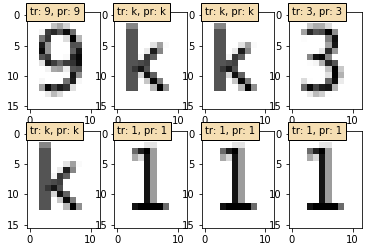

In [108]:
# observe prediction or random cases
def random_plot(X, y, predicted):
    indices = np.random.choice(len(X), 8)
    count = 0
    for i in indices:
        count += 1
        ax = plt.subplot(2, 4, count)
        ax.imshow(X[i], cmap='gray')
        ax.text(0, 0, 
                'tr: %s, pr: %s' % (y[i].decode('utf-8'), predicted[i].decode('utf-8')), \
                bbox={'facecolor':"wheat"})
    plt.show(block=False)

pred = fit.predict(X_test)
random_plot(X_test, Y_test, pred)


In [109]:
# Check the robustness to small variation
def generate_augmented_data(X, Y, target_size, seed=87):
    datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, 
                                 data_format='channels_last', channel_shift_range=0.25)
    out_X = None
    out_Y = None
    for x,y in datagen.flow(np.expand_dims(X, axis=4), Y, seed=seed):
        if out_X is None:
            out_X = x
            out_Y = y
        else:
            out_X = np.vstack([out_X, x])
            out_Y = np.concatenate([out_Y, y])
        if len(out_Y) >= target_size: 
            break
    out_X = out_X.squeeze()
    return out_X, out_Y

X_generated, Y_generated = generate_augmented_data(X_test, Y_test, 500)

             precision    recall  f1-score   support

       b'0'       0.67      0.50      0.57        16
       b'1'       0.86      0.59      0.70       100
       b'2'       0.81      0.43      0.57        30
       b'3'       0.08      0.20      0.12        20
       b'4'       0.34      0.55      0.42        20
       b'5'       0.91      0.45      0.61        22
       b'6'       0.40      0.30      0.34        20
       b'7'       0.42      0.75      0.54        20
       b'8'       0.21      0.27      0.24        22
       b'9'       0.58      0.29      0.39        24
       b'd'       0.35      0.50      0.41        26
       b'k'       0.89      0.91      0.90       182

avg / total       0.71      0.63      0.65       502



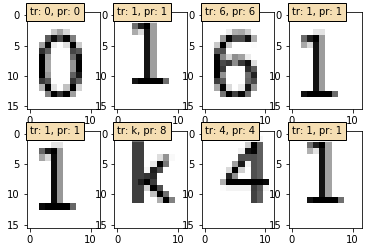

In [110]:
predicted = fit.predict(X_generated) 
print(classification_report(Y_generated, predicted))
#print(confusion_matrix(Y_generated, prdicted))
random_plot(X_generated, Y_generated, predicted)

In [111]:
# train the model with augmented data set
X_train_gen, Y_train_gen = generate_augmented_data(X_train, Y_train, 5000)
fit = pipe.fit(X_train_gen, Y_train_gen)

X_test_gen, Y_test_gen = generate_augmented_data(X_test, Y_test, 5000)

pred = fit.predict(X_test_gen)

In [112]:
# performance on the original test data
fit.score(X_test, Y_test)

1.0

In [113]:
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',141,0,0,0,0,0,0,0,2,2,15,0,160
b'1',0,930,24,32,0,1,0,0,10,3,0,0,1000
b'2',0,6,293,0,0,1,0,0,0,0,0,0,300
b'3',0,1,24,163,0,6,0,2,4,0,0,0,200
b'4',0,0,2,0,173,3,0,0,2,5,15,0,200
b'5',0,0,2,4,0,206,0,0,5,3,0,0,220
b'6',5,0,0,0,0,0,158,0,32,3,2,0,200
b'7',0,0,35,0,0,0,0,155,0,8,2,0,200
b'8',0,0,0,0,0,0,47,0,173,0,0,0,220


In [114]:
print(classification_report(Y_test_gen, pred))

             precision    recall  f1-score   support

       b'0'       0.88      0.88      0.88       160
       b'1'       0.99      0.93      0.96      1000
       b'2'       0.77      0.98      0.86       300
       b'3'       0.81      0.81      0.81       200
       b'4'       0.99      0.86      0.93       200
       b'5'       0.95      0.94      0.94       220
       b'6'       0.76      0.79      0.77       200
       b'7'       0.99      0.78      0.87       200
       b'8'       0.50      0.79      0.61       220
       b'9'       0.90      1.00      0.94       240
       b'd'       0.86      0.82      0.84       260
       b'k'       1.00      0.94      0.97      1820

avg / total       0.93      0.91      0.91      5020



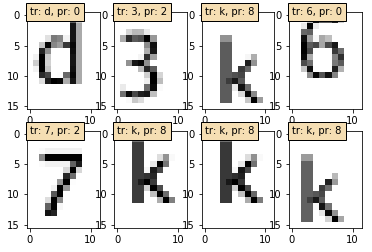

In [115]:
wrong = (Y_test_gen != pred)
random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [116]:
# Try more complex model with polynomial terms
pipe2 = Pipeline([
    ('flatten data to "obs*feature" shape', MyTrans()), 
    ('Make polynomial features', PolynomialFeatures(degree=2, interaction_only=True)),
    ('fit to gaussian naive bayes', GaussianNB())
])
fit = pipe2.fit(X_train_gen, Y_train_gen)

In [117]:
pred = fit.predict(X_test_gen)

In [118]:
pd.crosstab(pd.Series(Y_test_gen), pd.Series(pred), margins=True)

col_0,b'0',b'1',b'2',b'3',b'4',b'5',b'6',b'7',b'8',b'9',b'd',b'k',All
row_0,,,,,,,,,,,,,
b'0',143,0,0,0,0,0,1,0,1,0,15,0,160
b'1',0,877,16,59,0,0,0,0,45,3,0,0,1000
b'2',0,0,289,0,1,0,0,0,10,0,0,0,300
b'3',0,2,12,146,3,17,0,2,18,0,0,0,200
b'4',0,0,2,0,171,2,0,0,3,7,15,0,200
b'5',0,0,2,0,0,198,0,0,17,3,0,0,220
b'6',5,0,0,0,0,0,161,0,31,3,0,0,200
b'7',0,0,37,0,0,0,0,150,1,10,2,0,200
b'8',0,0,0,0,0,0,34,0,182,4,0,0,220


In [119]:
print(classification_report(Y_test_gen, pred))

             precision    recall  f1-score   support

       b'0'       0.85      0.89      0.87       160
       b'1'       1.00      0.88      0.93      1000
       b'2'       0.81      0.96      0.88       300
       b'3'       0.71      0.73      0.72       200
       b'4'       0.97      0.85      0.91       200
       b'5'       0.90      0.90      0.90       220
       b'6'       0.81      0.81      0.81       200
       b'7'       0.99      0.75      0.85       200
       b'8'       0.40      0.83      0.54       220
       b'9'       0.89      1.00      0.94       240
       b'd'       0.87      0.87      0.87       260
       b'k'       1.00      0.93      0.96      1820

avg / total       0.92      0.89      0.90      5020



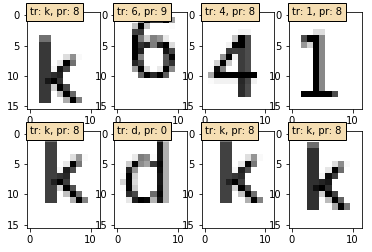

In [120]:
wrong = (Y_test_gen != pred)
random_plot(X_test_gen[wrong], Y_test_gen[wrong], pred[wrong])

In [121]:
# performance on the original test data
fit.score(X_test, Y_test)

1.0